In [1]:
# Imports
import pandas as pd
import numpy as np
from tqdm import tqdm

# Transformers
import transformers
from transformers import AutoTokenizer, AutoModel

# Model creation 
import torch
from torch import nn
import torch.nn.functional as F

# Dataset & Dataloader
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Optimizer 
from torch.optim import Adam

# Schedular
from torch.optim.lr_scheduler import ReduceLROnPlateau

# TQDM
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
import torch

# Исходные данные
data = [
    (torch.tensor([[101, 10400, 14102, 20426],
                   [101, 10400, 14102, 20666]]), torch.tensor([0.0004, 0.02])),
    (torch.tensor([[101, 10400, 14102, 12179],
                   [101, 10400, 14102, 12179]]), torch.tensor([0.0004, 0.0002])),
    (torch.tensor([[101, 10400, 14102, 16230],
                   [101, 10400, 14102, 16230]]), torch.tensor([0.0004, 0.0002]))
]

# Функция для сортировки батча по вероятностям
def sort_batch_by_probability(batch):
    sequences, probabilities = batch
    sorted_indices = torch.argsort(probabilities, descending=True)
    sorted_sequences = sequences[sorted_indices]
    sorted_probabilities = probabilities[sorted_indices]
    return sorted_sequences, sorted_probabilities

# Сортируем каждый батч
sorted_data = [sort_batch_by_probability(batch) for batch in data]

# Выводим отсортированные данные для проверки
for tensors in sorted_data:
    print(tensors)

(tensor([[  101, 10400, 14102, 20666],
        [  101, 10400, 14102, 20426]]), tensor([0.0200, 0.0004]))
(tensor([[  101, 10400, 14102, 12179],
        [  101, 10400, 14102, 12179]]), tensor([0.0004, 0.0002]))
(tensor([[  101, 10400, 14102, 16230],
        [  101, 10400, 14102, 16230]]), tensor([0.0004, 0.0002]))


In [3]:
sorted_data[:3]

[(tensor([[  101, 10400, 14102, 20666],
          [  101, 10400, 14102, 20426]]),
  tensor([0.0200, 0.0004])),
 (tensor([[  101, 10400, 14102, 12179],
          [  101, 10400, 14102, 12179]]),
  tensor([0.0004, 0.0002])),
 (tensor([[  101, 10400, 14102, 16230],
          [  101, 10400, 14102, 16230]]),
  tensor([0.0004, 0.0002]))]

In [4]:
import os

# Set TOKENIZERS_PARALLELISM to true
os.environ["TOKENIZERS_PARALLELISM"] = "true"

# Data

In [27]:
train_df = pd.read_csv("/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv")
test_df = pd.read_csv("/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv")

In [6]:
#train_df = train_df.iloc[:50000]

# Tokenizer

In [7]:
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

# DataSet & DataLoader

In [28]:
seq_max_len = 300

class CustomDataset(Dataset):
    def __init__(self, data: pd.DataFrame, seq_max_len = seq_max_len):
        self.tokenizer = tokenizer
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        data_series = self.data.loc[index]
        text = data_series['highlights']
        return text

In [29]:
def custom_collate_fn(obj:list):
    
    tokenized_texts = tokenizer(obj,add_special_tokens = True, truncation = True, padding = "max_length", max_length = seq_max_len+1, return_tensors = 'pt')
    
    return tokenized_texts


train_dataset = CustomDataset(train_df)
train_dataloader = DataLoader(dataset = train_dataset,batch_size = 45,pin_memory = True,collate_fn = custom_collate_fn,num_workers = 0)

test_dataset = CustomDataset(test_df)
test_dataloader = DataLoader(dataset = test_dataset,batch_size = 45,pin_memory = True,collate_fn = custom_collate_fn,num_workers = 0)

In [10]:
loader_sample = next(iter(train_dataloader))

In [11]:
# SHAPE MUSE BE BSXSEQ_LEN
loader_sample['input_ids']

tensor([[  101,  3387,  2198,  ...,     0,     0,     0],
        [  101,  4735, 12087,  ...,     0,     0,     0],
        [  101,  7010, 14925,  ...,     0,     0,     0],
        ...,
        [  101,  5467,  8225,  ...,     0,     0,     0],
        [  101, 21372,  1998,  ...,     0,     0,     0],
        [  101,  2047,  1024,  ...,     0,     0,     0]])

# Model

In [12]:
block_size = seq_max_len
n_embd = 256
vocab_size = tokenizer.vocab_size
head_size = 6
device = ("cuda" if torch.cuda.is_available else "cpu")
print(device)

cuda


In [13]:
class Head(nn.Module):
    """ one head of self-attention """
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        # Создает операцию, дает ей имя, но она игнорируется при расчете градиента
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(p = 0.2)
        
    def forward(self, x):
        # B - batch, size, T - element of the sequence, C - Embeding for token
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * 8**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        #print(wei.shape)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        return wei
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class Head_Masked(nn.Module):
    """One head of self-attention with masking."""
    def __init__(self, head_size,dropout_prob=0.2):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)  # (B, T, head_size)
        q = self.query(x)  # (B, T, head_size)
        v = self.value(x)  # (B, T, head_size)

        # Compute attention scores
        scores = q @ k.transpose(-2, -1) * (1.0 / (k.shape[-1] ** 0.5))  # (B, T, T)

        # Apply mask
        #mask = attention_mask.unsqueeze(1) * attention_mask.unsqueeze(2)  # (B, 1, T) * (B, T, 1) -> (B, T, T)
        
        scores = scores.masked_fill(self.tril[:T,:T] == 0, float(-1e9))  # Apply lower triangular mask
        #scores = scores.masked_fill(mask[:T,:T] == 0, float(-1e9))  # Apply attention mask
        
        # Normalize the scores
        attn = F.softmax(scores, dim=-1)  # (B, T, T)
        attn = self.dropout(attn)

        # Apply attention weights to values
        out = attn @ v  # (B, T, T) @ (B, T, head_size) -> (B, T, head_size)

        return out

In [14]:
x = torch.rand(size = (30,300,256))
x_att = torch.randint(low = 0,high = 2, size = (30,300))

In [15]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head_Masked(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(p = 0.2)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [16]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(p = 0.2),
        )

    def forward(self, x):
        return self.net(x)

In [17]:
class Block(nn.Module):
    
    """ Transformer block: communication followed by computation """
    
    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        # head_size почему то деление n_embd на кол-во голов attention
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [18]:
block_size = seq_max_len
n_embd = 512
vocab_size = tokenizer.vocab_size
n_layer = 6
n_head = 8
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class GPT_Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.ModuleList([Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)  # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
        self.entropy_reg = 0.3

    def forward(self, x):
        x = x.to(device)
                
        x_batched_input_ids = x['input_ids'][:,1:]
        x_batched_attention_mask = x['attention_mask'][:,1:]
        
        # Cохранили размерности наших ответов
        B, T = x_batched_input_ids.size(0),x_batched_input_ids.size(1)
        
        base_tensor = torch.tensor([101]+[103]*(T-1), device = device).repeat(B,1)
        
        tok_emb = self.token_embedding_table(base_tensor)  # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))  # (T,C)
        
        x = tok_emb + pos_emb  # (B,T,C)
        
        for block in self.blocks:
            x = block(x)
        
        x = self.ln_f(x)  # (B,T,C)
        logits = self.lm_head(x)  # (B,T,vocab_size)
        
        # Calculate loss
        loss = F.cross_entropy(logits.permute(0,2,1), x_batched_input_ids)
        
#         # Compute entropy regularization
#         probs = F.softmax(logits, dim=-1)
#         log_probs = F.log_softmax(logits, dim=-1)
#         entropy = -torch.sum(probs * log_probs, dim=-1).mean()
        
#         loss = loss - self.entropy_reg * entropy
        
        return loss

    @torch.inference_mode()
    def generate(self, starting_seq: torch.tensor):
        self.eval()
        starting_seq = starting_seq.to(device)
        B,T_start = starting_seq.shape
        
        tail_tensor = torch.tensor([103]*(seq_max_len-T_start), device = device).repeat(B,1)
        
        
        base_tensor = torch.cat((starting_seq,tail_tensor), dim = -1)
        base_tensor = base_tensor[:,:seq_max_len]
        #print(base_tensor.shape)
    
        tok_emb = self.token_embedding_table(base_tensor)
        pos_emb = self.position_embedding_table(torch.arange(seq_max_len, device=device))
        
        x = tok_emb + pos_emb 
        
        for block in self.blocks:
            x = block(x) 
        x = self.ln_f(x)
        logits = self.lm_head(x)
        
        return logits
    
    @torch.inference_mode()
    def generate_v2(self, starting_seq: torch.tensor, n_generate: int):
        self.eval()
        starting_seq = starting_seq.to(device)
        generated_seq = starting_seq
        
        for generation_iteration in range(n_generate):
            B,T = generated_seq.shape
            
            tok_emb = self.token_embedding_table(generated_seq)  # (B,T,C)
            pos_emb = self.position_embedding_table(torch.arange(T, device=device))  # (T,C)
            x = tok_emb + pos_emb 
            
            for block in self.blocks:
                x = block(x) 
            
            x = self.ln_f(x)
            logits = self.lm_head(x)
            
            # taking all batches, but only last token
            generated_token = torch.argmax(logits, dim = -1)[:,-1].view(B,-1)
            generated_seq = torch.cat((generated_seq,generated_token), dim = -1)
            
        return generated_seq
    
    @torch.inference_mode()
    def beam_search(self, starting_seq: torch.tensor, n_generate: int, beam_width: int):
        self.eval()
        B = starting_seq.size(0)
        sequences = [(starting_seq, torch.zeros(B, 1, device=device))]

        for _ in range(n_generate):
            all_candidates = []
            for seq, score in sequences:
                tok_emb = self.token_embedding_table(seq)  # (B, T, C)
                pos_emb = self.position_embedding_table(torch.arange(seq.size(1), device= device))  # (T, C)
                x = tok_emb + pos_emb 
                
                for block in self.blocks:
                    x = block(x)
                
                x = self.ln_f(x)
                logits = self.lm_head(x)
                
                log_probs = F.softmax(logits[:, -1, :], dim=-1)
                
                # Create a mask to zero out 50% of the log_probs
                mask = torch.rand(log_probs.shape, device= device) < 0.5
                log_probs = log_probs.masked_fill(mask, 0)
                
                top_log_probs, top_indices = torch.topk(log_probs, beam_width, dim=-1)
                
                for i in range(beam_width):
                    candidate_seq = torch.cat([seq, top_indices[:, i].unsqueeze(-1)], dim=-1)
                    candidate_score = score + top_log_probs[:, i].unsqueeze(-1)
                    all_candidates.append((candidate_seq, candidate_score))
            
            ordered = sorted(all_candidates, key=lambda tup: tup[1].max().item(), reverse=True)
            sequences = ordered[:beam_width]

        best_seq = sequences[0][0]
        return best_seq
    
    @torch.inference_mode()
    def beam_generate(self, starting_seq: torch.tensor, n_generate: int, beam_width: int = 3):
        self.eval()
        return self.beam_search(starting_seq, n_generate, beam_width)

cuda


In [19]:
torch.cuda.empty_cache()
model = GPT_Model()
model.to(device)
print()

In [20]:
#model.forward(loader_sample)

In [35]:
bs = 2
starting_tensor = torch.tensor([[101,15002],[101,16002]], device = device)

for text in model.beam_generate(starting_tensor,25):
    print(tokenizer.decode(text.tolist()))
    print()

[CLS] subscription : s the the a the the the the a the the the the the'the the'the the'the the a

[CLS] 80s :, to, a the a the the a. the'the'a of. the the.., the the



In [22]:
# bs = 2
# starting_tensor = torch.tensor([101]).repeat(bs,1)

# for text in model.generate_v2(starting_tensor,5):
#     print(tokenizer.decode(text.tolist()))
#     print()

# Training Zone

In [23]:
optimizer = Adam(model.parameters(), lr = 1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

In [24]:
# def train(model):
#     iteration = 0
#     total_loss = 0
#     model.train()
#     for x in tqdm(train_dataloader, desc = "Training"):
        
#         if iteration == 2:
#             return total_loss
#         iteration += 1
#         optimizer.zero_grad()
        
#         loss = model.forward(x)
#         loss.backward()
#         optimizer.step()
        
#         total_loss+= loss.item()
        
#     return total_loss

In [25]:
# Установка параметров
num_epochs = 99
learning_rate = 1e-4

# Тренировочная функция для одной эпохи
def train_one_epoch(model, dataloader, optimizer):
    model.train()
    total_loss = 0
    for x in tqdm(dataloader, desc="Training"):    
        optimizer.zero_grad()
        
        loss = model.forward(x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / len(dataloader)
    return average_loss

# Тренировочная функция для одной эпохи

@torch.inference_mode()
def validation_one_epoch(model, dataloader, optimizer):
    model.eval()
    total_loss = 0
    for x in tqdm(dataloader, desc="Validation"):
        loss = model.forward(x)
        total_loss += loss.item()
    average_loss = total_loss / len(dataloader)
    return average_loss

def plot_stats(
    train_loss: list[float],
    test_loss: list[float],
    title: str):
    
    plt.figure(figsize=(8, 4))
    plt.title(title + ' loss')
    plt.plot(train_loss, label='Train loss')
    plt.plot(test_loss, label='Test loss')
    plt.legend()
    plt.grid()

    plt.show()

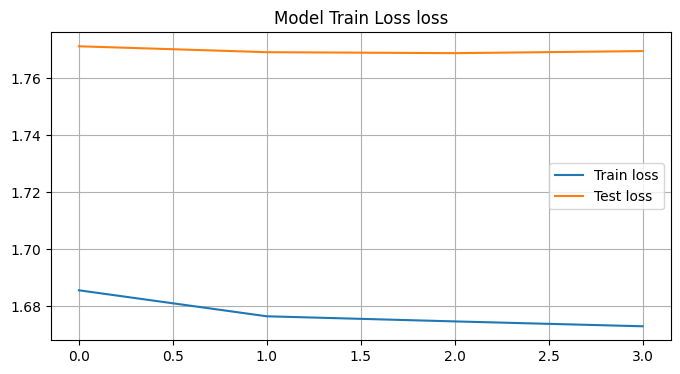

Epoch 4/99, Train Loss: 1.6730,Test Loss: 1.7694


Training:  99%|█████████▉| 6320/6381 [1:15:36<00:43,  1.39it/s]

In [ ]:
# Основной цикл обучения
train_loss_per_epoch = []
test_loss_per_epoch = []

for epoch in range(num_epochs):
    average_loss_train = train_one_epoch(model, train_dataloader, optimizer)
    average_loss_test = validation_one_epoch(model, test_dataloader, optimizer)
    train_loss_per_epoch.append(average_loss_train)
    test_loss_per_epoch.append(average_loss_test)
    

    # График
    clear_output()
    plot_stats(train_loss_per_epoch,test_loss_per_epoch,"Model Train Loss")
    
    # Вызов планировщика после каждой эпохи
    scheduler.step(average_loss_train)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_loss_train:.4f},Test Loss: {average_loss_test:.4f}')
    
    # Сохранение модели после каждой эпохи (можно добавить условие, чтобы сохранять только при улучшении)
    torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pt')

# Сохранение обученной модели в конце
with open('model.pkl', 'wb') as f:
    pickle.dump(model.state_dict(), f)

In [32]:
from IPython.display import FileLink
FileLink('model_epoch_7.pt')

/kaggle/working/model_epoch_7.pt